In [1]:
import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.models import resnet50
from torchinfo import summary
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
SEED = 42
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
DATA_DIR = '../data'
RAW_DIR = os.path.join(DATA_DIR, 'raw')
MODELS_SAVE_DIR = '../models'
IMG_DIR = os.path.join(RAW_DIR, 'images')
MASK_DIR = os.path.join(RAW_DIR, 'masks')

In [5]:
TRAIN_SIZE = 0.7
VAL_TEST_SPLIT = 0.5

IMAGE_SIZE = 640
IMAGE_CHANNELS = 3
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

#### Loading the dataset and visualizing samples

In [6]:
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(),
    ToTensorV2()
])

In [7]:
images_paths = [os.path.join(IMG_DIR, img) for img in os.listdir(IMG_DIR)]
masks_paths = [os.path.join(MASK_DIR, mask) for mask in os.listdir(MASK_DIR)]

images_paths.sort()
masks_paths.sort()

print(f'Images: {len(images_paths)}')
print(f'Masks: {len(masks_paths)}')

data_df = pd.DataFrame({
    'image_path': images_paths,
    'mask_path': masks_paths
})
data_df.head()

Images: 286
Masks: 286


,image_path,mask_path
0,../data\raw\images\1.jpg,../data\raw\masks\1.png
1,../data\raw\images\10.jpg,../data\raw\masks\10.png
2,../data\raw\images\1000.jpg,../data\raw\masks\1000.png
3,../data\raw\images\1001.jpg,../data\raw\masks\1001.png
4,../data\raw\images\1002.jpg,../data\raw\masks\1002.png


In [8]:
for im, msk in zip(images_paths, masks_paths):
    img = plt.imread(im)
    mask = plt.imread(msk)
    if img.shape[0] != mask.shape[0] or img.shape[1] != mask.shape[1]:
        print(img.shape, mask.shape)
        print(im, msk)
        print(f'Index {images_paths.index(im)}')
        os.remove(im)
        os.remove(msk)

In [8]:
train_df, other_df = train_test_split(data_df, train_size=TRAIN_SIZE, random_state=SEED)
val_df, test_df = train_test_split(other_df, test_size=VAL_TEST_SPLIT, random_state=SEED)

In [9]:
print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')

Train: 200, Val: 43, Test: 43


In [10]:
def mask_preprocess(mask):
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    return mask

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = plt.imread(img_path)
        mask = plt.imread(mask_path)
        mask = mask_preprocess(mask)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        mask = mask.unsqueeze(0)
        
        return image, mask

In [12]:
train = CustomDataset(train_df, transform=train_transform)
val = CustomDataset(val_df, transform=val_transform)
test = CustomDataset(test_df, transform=val_transform)

In [13]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

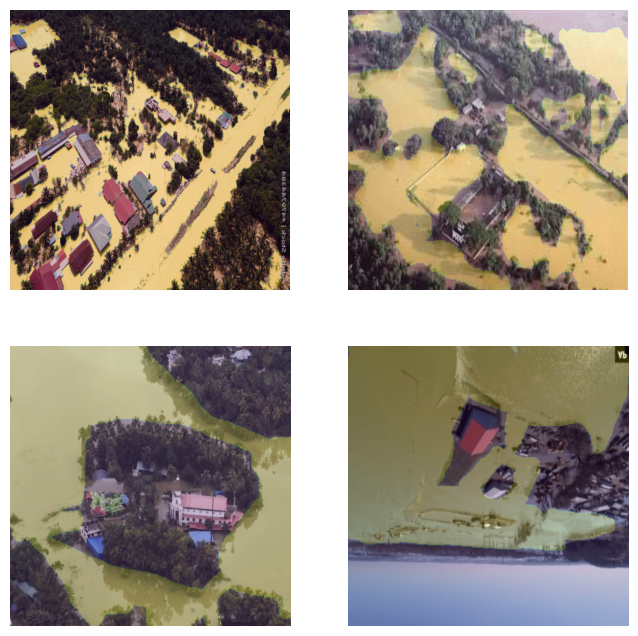

In [14]:
images_sample = next(iter(train_loader))

fig = plt.figure(figsize=(8, 8))
cols, rows = 2, 2

for i in range(cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(np.clip(images_sample[0][i].permute(1, 2, 0).numpy()*[0.229, 0.224, 0.225]+[0.485, 0.456, 0.406], 0, 1))
    plt.imshow(images_sample[1][i][0].numpy(), alpha=0.2)
    plt.axis('off')
plt.show()

#### Building model and blocks

In [ ]:
class DilatedConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1x1 = DilatedConvBlock(in_channels, out_channels, 1, 0, 1)
        self.conv3x3_6 = DilatedConvBlock(in_channels, out_channels, 3, 6, 6)
        self.conv3x3_12 = DilatedConvBlock(in_channels, out_channels, 3, 12, 12)
        self.conv3x3_18 = DilatedConvBlock(in_channels, out_channels, 3, 18, 18)
        self.avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.ReLU()
        )
        self.conv1x1_out = DilatedConvBlock(out_channels*5, out_channels, 1, 0, 1)

    def forward(self, x):
        x1x1 = self.conv1x1(x)
        x3x3_6 = self.conv3x3_6(x)
        x3x3_12 = self.conv3x3_12(x)
        x3x3_18 = self.conv3x3_18(x)
        avg_pool = self.avg_pool(x)
        avg_pool = nn.functional.interpolate(avg_pool, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x1x1, x3x3_6, x3x3_12, x3x3_18, avg_pool], dim=1)
        x = self.conv1x1_out(x)
        return x

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = resnet50()
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.aspp = ASPP(1024, 256)
        self.conv1x1 = DilatedConvBlock(256, 48, 1, 0, 1)
        self.conv3x3 = DilatedConvBlock(304, 256, 3, 1, 1)
        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        low_level_features = self.backbone[:-3](x)
        x = self.backbone[:-1](x)
        x = self.aspp(x)
        x = nn.functional.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        low_level_features = self.conv1x1(low_level_features)
        x = torch.cat([x, low_level_features], dim=1)
        x = self.conv3x3(x)
        x = nn.functional.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        x = self.classifier(x)
        return x

In [15]:
deeplab = DeepLabV3Plus(1).to(device)
summary(deeplab, input_size=(1, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                        Output Shape              Param #
DeepLabV3Plus                                 [1, 1, 640, 640]          --
├─Sequential: 1-1                             --                        14,964,736
│    └─Conv2d: 2-1                            [1, 64, 320, 320]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 320, 320]         128
│    └─ReLU: 2-3                              [1, 64, 320, 320]         --
│    └─MaxPool2d: 2-4                         [1, 64, 160, 160]         --
│    └─Sequential: 2-5                        [1, 256, 160, 160]        --
│    │    └─Bottleneck: 3-1                   [1, 256, 160, 160]        75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 160, 160]        70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 160, 160]        70,400
│    └─Conv2d: 2-6                            [1, 64, 320, 320]         (recursive)
│    └─BatchNorm2d: 2-7                       [1, 64, 320, 320

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        intersection = (y_pred * y_true).sum()
        return 1 - ((2. * intersection + 1e-7) / (y_pred.sum() + y_true.sum() + 1e-7))
    
class IoU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum() - intersection
        return (intersection + 1e-7) / (union + 1e-7)

In [17]:
model = DeepLabV3Plus(1).to(device)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
iou_metric = IoU()

In [18]:
def train_epoch(model, loader, criterion, metric, optimizer, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    loop = tqdm(loader)
    for img, label in loop:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        preds = model(img)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        iou = metric(preds, label).item()
        running_iou += iou
        loop.set_description(f'Epoch {epoch + 1}/{num_epochs}')
        loop.set_postfix(loss=loss.item(), iou=iou)

    return running_loss / len(loader), running_iou / len(loader)


def val_epoch(model, loader, criterion, metric, epoch, num_epochs):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    loop = tqdm(loader)
    with torch.no_grad():
        for img, label in loop:
            img, label = img.to(device), label.to(device)
            preds = model(img)
            loss = criterion(preds, label)
            running_loss += loss.item()
            iou = metric(preds, label).item()
            running_iou += iou
            loop.set_description(f'Epoch {epoch + 1}/{num_epochs}')
            loop.set_postfix(loss=loss.item(), accuracy=iou)

    return running_loss / len(loader), running_iou / len(loader)


def test_model(model, metric, loader):
    model.eval()
    running_iou = 0.0
    img_list = []
    preds_list = []
    labels_list = []
    loop = tqdm(loader)
    with torch.no_grad():
        for img, label in loop:
            img, label = img.to(device), label.to(device)
            preds = model(img)
            running_iou += metric(preds, label)
            img_list.append(img)
            preds_list.append(preds)
            labels_list.append(label)

    return running_iou / len(loader), torch.cat(img_list), torch.cat(preds_list), torch.cat(labels_list)


def train_model(model, train_loader, val_loader, criterion, metric, optimizer, num_epochs):
    train_losses = []
    train_ious = []
    val_losses = []
    val_ious = []
    for epoch in range(num_epochs):
        train_loss, train_iou = train_epoch(model, train_loader, criterion, metric, optimizer, epoch, num_epochs)
        val_loss, val_iou = val_epoch(model, val_loader, criterion, metric, epoch, num_epochs)
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        print(f'Training Loss: {train_loss:.4f}, Training IoU: {train_iou:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}')
    return train_losses, train_ious, val_losses, val_ious

In [19]:
train_losses, train_ious, val_losses, val_ious = train_model(model, train_loader, val_loader, criterion, iou_metric, optimizer, NUM_EPOCHS)

with open(os.path.join(MODELS_SAVE_DIR, 'metrics.pkl'), 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'train_ious': train_ious,
        'val_losses': val_losses,
        'val_ious': val_ious
    }, f)

torch.save(model.state_dict(), os.path.join(MODELS_SAVE_DIR, 'deeplabv3plus.pth'))

Epoch 1/10: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s, accuracy=0.604, loss=0.247]


Training Loss: 0.3593, Training IoU: 0.4824
Validation Loss: 0.2550, Validation IoU: 0.5961


Epoch 2/10: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s, accuracy=0.62, loss=0.235] 


Training Loss: 0.2347, Training IoU: 0.6223
Validation Loss: 0.2447, Validation IoU: 0.6088


Epoch 3/10: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s, accuracy=0.647, loss=0.215]


Training Loss: 0.2223, Training IoU: 0.6384
Validation Loss: 0.2282, Validation IoU: 0.6313


Epoch 4/10: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, accuracy=0.665, loss=0.201]


Training Loss: 0.2248, Training IoU: 0.6364
Validation Loss: 0.2227, Validation IoU: 0.6377


Epoch 5/10: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, accuracy=0.64, loss=0.22]  


Training Loss: 0.2034, Training IoU: 0.6644
Validation Loss: 0.2214, Validation IoU: 0.6402


Epoch 6/10: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, accuracy=0.632, loss=0.225]


Training Loss: 0.2030, Training IoU: 0.6654
Validation Loss: 0.2210, Validation IoU: 0.6409


Epoch 7/10: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, accuracy=0.724, loss=0.16] 


Training Loss: 0.1928, Training IoU: 0.6797
Validation Loss: 0.1993, Validation IoU: 0.6712


Epoch 8/10: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, accuracy=0.661, loss=0.204]


Training Loss: 0.1833, Training IoU: 0.6948
Validation Loss: 0.2009, Validation IoU: 0.6675


Epoch 9/10: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, accuracy=0.702, loss=0.175]


Training Loss: 0.1813, Training IoU: 0.6955
Validation Loss: 0.1972, Validation IoU: 0.6740


Epoch 10/10: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, accuracy=0.663, loss=0.203]


Training Loss: 0.1781, Training IoU: 0.6997
Validation Loss: 0.2047, Validation IoU: 0.6626


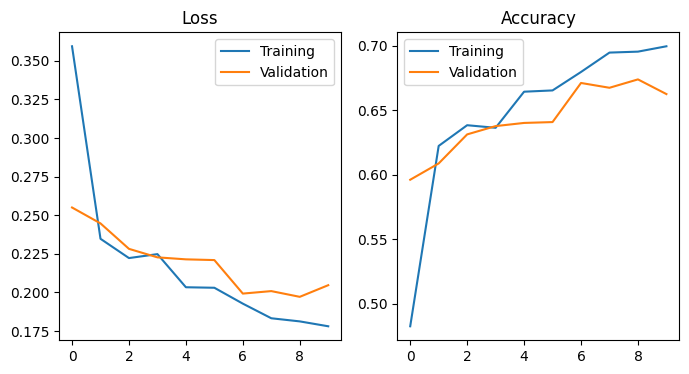

In [20]:
def plot_metrics(train_losses, train_ious, val_losses, val_ious):
    fig = plt.figure(figsize=(8, 4))
    cols, rows = 2, 1
    for i, (train, val) in enumerate([(train_losses, val_losses), (train_ious, val_ious)]):
        fig.add_subplot(rows, cols, i+1)
        plt.plot(train, label='Training')
        plt.plot(val, label='Validation')
        plt.legend()

        plt.title(f'Loss' if i == 0 else f'Accuracy')
    plt.show()


plot_metrics(train_losses, train_ious, val_losses, val_ious)

In [21]:
#model.load_state_dict(torch.load(f'{MODELS_SAVE_DIR}/{deeplabv3plus}.pth'))
iou, imgs, preds, labels = test_model(model, iou_metric, test_loader)
print(f'Test IoU: {iou:.4f}')

100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

Test IoU: 0.6762


In [22]:
def plot_predictions(img, pred, true):
    fig = plt.figure(figsize=(15, 10))

    fig.add_subplot(1, 3, 1)
    plt.imshow(np.clip(img.permute(1, 2, 0).detach().cpu().numpy()*[0.229, 0.224, 0.225]+[0.485, 0.456, 0.406], 0, 1))
    plt.axis('off')
    plt.title('Image')
    fig.add_subplot(1, 3, 2)
    #plt.imshow(pred[0].detach().cpu().numpy(), cmap='gray')
    plt.imshow(mask_preprocess(torch.sigmoid(pred[0]).detach().cpu().numpy()), cmap='gray')
    plt.axis('off')
    plt.title('Prediction')
    fig.add_subplot(1, 3, 3)
    plt.imshow(true[0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title('True Mask')
    plt.show()

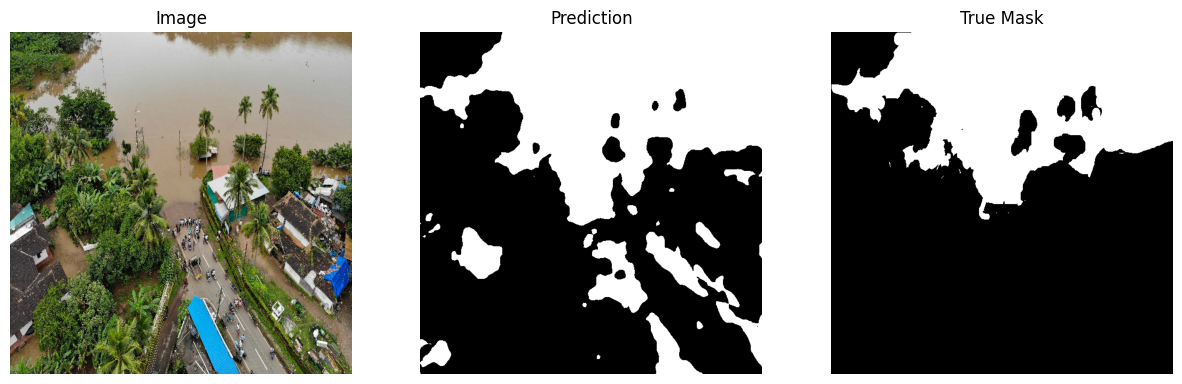

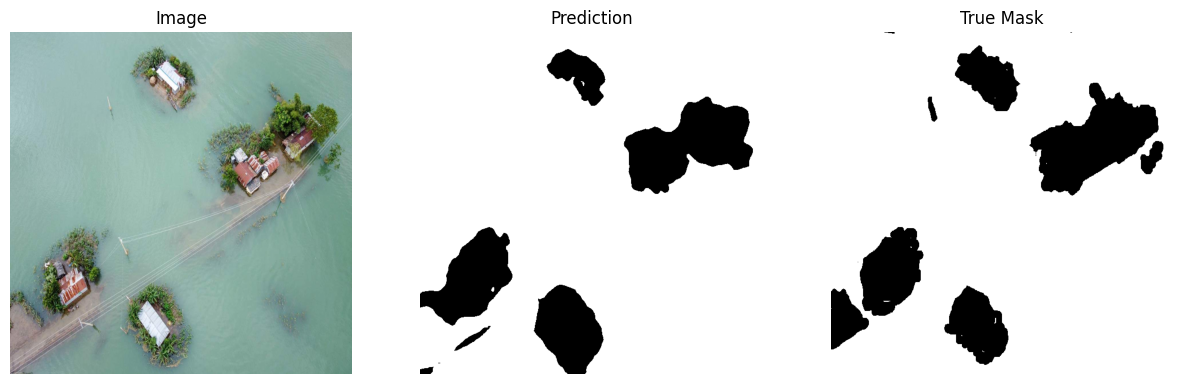

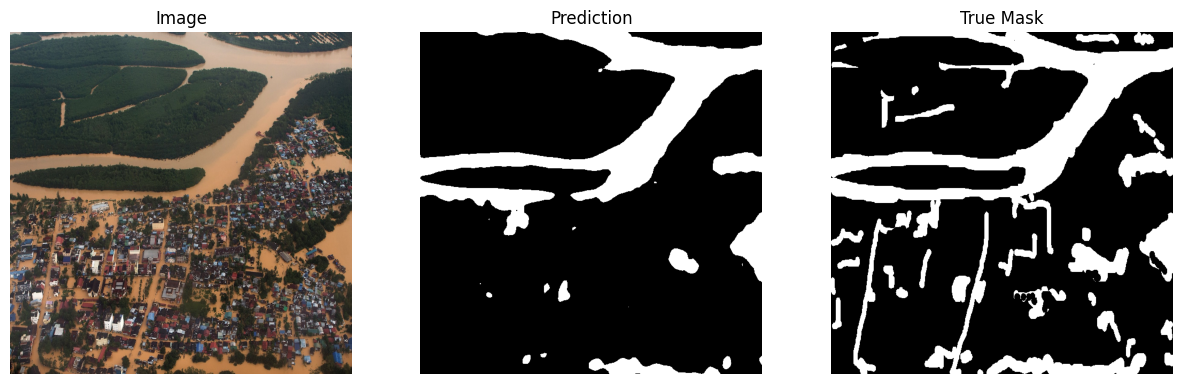

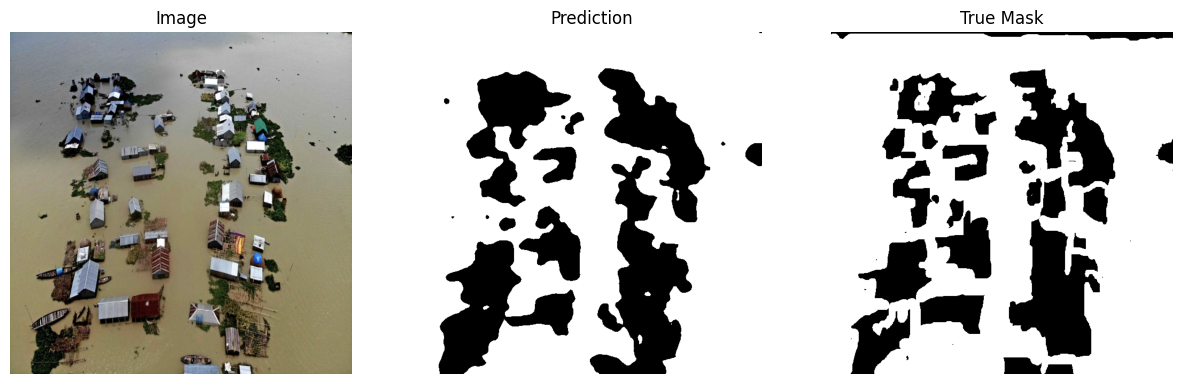

In [43]:
index = 2
plot_predictions(imgs[index], preds[index], labels[index])
index = 5
plot_predictions(imgs[index], preds[index], labels[index])
index = 8
plot_predictions(imgs[index], preds[index], labels[index])
index = 31
plot_predictions(imgs[index], preds[index], labels[index])